# DP-SFT Baseline Experiment: Differentially Private Fine-Tuning Training & Audit

This notebook runs the full DP-SFT (Differentially Private Supervised Fine-Tuning) baseline experiment pipeline:

1. **Environment Setup** — Install dependencies such as Opacus
2. **Clipping Norm Calibration** (Optional) — Estimate a reasonable gradient clipping threshold
3. **Experiment Matrix Generation** — Generate ε × seed training configurations (pilot or full)
4. **Training Loop** — Iterate through the matrix to run DP-SFT training; log failures and continue
5. **Audit Loop** — Run privacy audits on all trained models
6. **Statistical Analysis + Visualization** — Effect sizes across ε, Bootstrap CI, trend plots

**Experiment Matrix:**
- Full: ε ∈ {∞, 8, 4, 1} × 3 seeds = 12 runs
- Pilot: ε ∈ {∞, 4, 1} × 1 seed = 3 runs

**Prerequisites:**
- Colab GPU runtime (T4 or higher recommended)
- Upload the project `src/` and `data/` directories to Colab
- Base model `models/Qwen2.5-0.5B-Instruct/` will be auto-downloaded from HuggingFace if not present

## 1. Environment Setup

In [3]:
!pip install opacus>=1.4.0
!pip install torch==2.5.1 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.46.3 peft==0.13.2 trl==0.12.2
!pip install torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 140.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 118.5 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.25.0+cu128
    Uninstalling torchvision-0.25.0+cu128:
      Successfully uninstalled torchvision-0.25.0+cu128
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.10.0+cu128
    Uninstalling torchaudio-2.10.0+cu128:
      Successfully uninstalled torchaudio-2.10.0+cu128


In [1]:
import torch, torchvision
print(f"torch={torch.__version__}, torchvision={torchvision.__version__}")
# Expected output: torch=2.5.1+cu121, torchvision=0.20.1+cu121


torch=2.5.1+cu121, torchvision=0.20.1+cu121


### Download Base Model

If `models/Qwen2.5-0.5B-Instruct/model.safetensors` does not exist,
it will be automatically downloaded from HuggingFace Hub.

In [2]:
import os
BASE_MODEL_DIR = "models/Qwen2.5-0.5B-Instruct"
WEIGHTS_FILE = os.path.join(BASE_MODEL_DIR, "model.safetensors")

if not os.path.isfile(WEIGHTS_FILE):
    print(f"[INFO] {WEIGHTS_FILE} not found, downloading from HuggingFace...")
    from huggingface_hub import snapshot_download
    snapshot_download(
        repo_id="Qwen/Qwen2.5-0.5B-Instruct",
        local_dir=BASE_MODEL_DIR,
        local_dir_use_symlinks=False,
    )
    print(f"[INFO] Download complete: {BASE_MODEL_DIR}")
else:
    print(f"[OK] Base model already exists: {WEIGHTS_FILE}")

[INFO] models/Qwen2.5-0.5B-Instruct/model.safetensors not found, downloading from HuggingFace...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `snapshot_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Download complete: models/Qwen2.5-0.5B-Instruct


In [2]:
import os
import sys
import json
import subprocess
from pathlib import Path

# Ensure project root is in sys.path
PROJECT_ROOT = os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Verify key files exist
required_files = [
    "src/train_dp_sft.py",
    "src/dp_sft_config.py",
    "src/run_dp_sft_audit.py",
    "src/dp_sft_analysis.py",
    "data/wiki_trimmed_with_canary_50.jsonl",
]
for f in required_files:
    status = "OK" if os.path.exists(f) else "MISSING"
    print(f"  [{status}] {f}")

os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)
print("\nEnvironment ready.")

  [OK] src/train_dp_sft.py
  [OK] src/dp_sft_config.py
  [OK] src/run_dp_sft_audit.py
  [OK] src/dp_sft_analysis.py
  [OK] data/wiki_trimmed_with_canary_50.jsonl

Environment ready.


## 2. Clipping Norm Calibration (Optional)

Before formal DP training, run a few steps (without noise) to collect batch-level gradient norm
distribution as a reference for choosing the clipping norm C. Default C=1.0; adjust based on calibration results.

**Note:** This step requires a GPU and only needs to be run once. If a suitable C value is already known, this can be skipped.

In [6]:
!python src/train_dp_sft.py \
    --epsilon 8 \
    --delta 0.0001 \
    --calibrate-clipping \
    --output-dir /tmp/calibration \
    --training-data data/wiki_trimmed_with_canary_50.jsonl

Error: Base model directory not found: modles/Qwen2.5-0.5B-Instruct


## 3. Experiment Matrix Generation

Use `dp_sft_config.py` to generate the experiment matrix. Defaults to **pilot mode** (3 runs) for quick feasibility validation.

- Pilot: ε ∈ {∞, 4, 1}, 1 seed → 3 runs
- Full: ε ∈ {∞, 8, 4, 1}, 3 seeds → 12 runs

To switch to full mode: simply remove the `--pilot` flag.

In [3]:
# Pilot mode (default) — 3 runs for quick feasibility check
!python -m src.dp_sft_config --pilot

# Full mode — uncomment below for complete 12-run matrix:
# !python -m src.dp_sft_config

=== DP-SFT Experiment Plan [PILOT MODE] ===
Total runs: 3
delta: 9.990010e-05 (N=10010)
clipping_norm: 1.0
accountant: rdp
training_data: data/wiki_trimmed_with_canary_50.jsonl
base_model: models/Qwen2.5-0.5B-Instruct

#    epsilon    seed     output_dir
------------------------------------------------------------
1    inf        42       models/dp_sft_eps_inf_seed42
2    4          42       models/dp_sft_eps4_seed42
3    1          42       models/dp_sft_eps1_seed42

To expand to full matrix, run:
  python -m src.dp_sft_config --epsilon-list inf 8 4 1 --seed-list 42 123 456


In [4]:
# Load experiment matrix into Python for the training loop
from src.dp_sft_config import parse_args, generate_experiment_matrix

# Use --pilot for pilot mode; remove for full matrix
args = parse_args(["--pilot", "--clipping-norm", "10.0"])
# args = parse_args([])  # Uncomment for full matrix

configs = generate_experiment_matrix(args)
print(f"Generated {len(configs)} run configurations:")
for i, cfg in enumerate(configs, 1):
    print(f"  {i}. epsilon={cfg['epsilon']}, seed={cfg['seed']}, "
          f"output_dir={cfg['output_dir']}")

Generated 3 run configurations:
  1. epsilon=inf, seed=42, output_dir=models/dp_sft_eps_inf_seed42
  2. epsilon=4, seed=42, output_dir=models/dp_sft_eps4_seed42
  3. epsilon=1, seed=42, output_dir=models/dp_sft_eps1_seed42


## 4. Training Loop

Iterate through the experiment matrix, executing each DP-SFT training run sequentially.

- Each run invokes `train_dp_sft.py` via `subprocess`
- Failed runs are logged and skipped without interrupting the full matrix (Req 8.6)
- After training completes, metadata is automatically written to `reports/run_metadata.jsonl`

In [7]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [8]:
results = []  # Track (config, status, error_msg)

for i, cfg in enumerate(configs, 1):
    print(f"\n{'='*60}")
    print(f"[{i}/{len(configs)}] Training: epsilon={cfg['epsilon']}, "
          f"seed={cfg['seed']}")
    print(f"  Output: {cfg['output_dir']}")
    print(f"{'='*60}")

    cmd = [
        sys.executable, "src/train_dp_sft.py",
        "--epsilon", str(cfg["epsilon"]),
        "--delta", str(cfg["delta"]),
        "--clipping-norm", str(cfg["clipping_norm"]),
        "--seed", str(cfg["seed"]),
        "--output-dir", cfg["output_dir"],
        "--training-data", cfg["training_data"],
        "--base-model", cfg["base_model"],
        "--accountant-type", cfg["accountant_type"],
    ]

    try:
        proc = subprocess.run(
            cmd, capture_output=True, text=True, timeout=3600
        )
        print(proc.stdout)
        if proc.stderr:
            print(f"[STDERR] {proc.stderr[-500:]}")

        if proc.returncode == 0:
            results.append((cfg, "success", None))
            print(f"  ✓ Completed successfully")
        else:
            error_msg = proc.stderr[-200:] if proc.stderr else "unknown error"
            results.append((cfg, "failed", error_msg))
            print(f"  ✗ Failed (exit code {proc.returncode})")

    except subprocess.TimeoutExpired:
        results.append((cfg, "timeout", "Exceeded 3600s timeout"))
        print(f"  ✗ Timeout")
    except Exception as e:
        results.append((cfg, "error", str(e)))
        print(f"  ✗ Error: {e}")

# Summary
print(f"\n{'='*60}")
print("Training Summary:")
n_success = sum(1 for _, s, _ in results if s == "success")
n_failed = len(results) - n_success
print(f"  Success: {n_success}/{len(results)}")
if n_failed > 0:
    print(f"  Failed: {n_failed}")
    for cfg, status, err in results:
        if status != "success":
            print(f"    - eps={cfg['epsilon']}, seed={cfg['seed']}: "
                  f"{status} — {err}")


[1/3] Training: epsilon=inf, seed=42
  Output: models/dp_sft_eps_inf_seed42
[INFO] epsilon=inf → standard SFT training (no DP noise)
[INFO] Loading tokenizer from models/Qwen2.5-0.5B-Instruct...
[INFO] Loading base model from models/Qwen2.5-0.5B-Instruct...
[INFO] Loading training data from data/wiki_trimmed_with_canary_50.jsonl...
[INFO] Dataset loaded: 10010 examples
trainable params: 2,162,688 || all params: 496,195,456 || trainable%: 0.4359
[INFO] Starting standard SFT training (epsilon=inf, seed=42)
{'loss': 2.4538, 'grad_norm': 0.17430473864078522, 'learning_rate': 0.00018400000000000003, 'epoch': 0.08}
{'loss': 2.4108, 'grad_norm': 0.22060392796993256, 'learning_rate': 0.000168, 'epoch': 0.16}
{'loss': 2.3869, 'grad_norm': 0.19085676968097687, 'learning_rate': 0.000152, 'epoch': 0.24}
{'loss': 2.3221, 'grad_norm': 0.17696253955364227, 'learning_rate': 0.00013600000000000003, 'epoch': 0.32}
{'loss': 2.3355, 'grad_norm': 0.2666381597518921, 'learning_rate': 0.00012, 'epoch': 0.4}

## 5. Audit Loop

Run privacy audits on all successfully trained DP-SFT models, computing token-level metrics
(Avg_LogProb, Avg_Rank, Canary_PPL) and classification-level metrics (Extraction_Rate, ROC_AUC, PR_AUC).

In pilot mode, secondary metrics are skipped to save compute time; CSV fields are filled with NA.

In [17]:
# Use --pilot for pilot mode; remove for full audit
!python -m src.run_dp_sft_audit \
    --model-dirs "models/dp_sft_eps*" \
    --pilot

# Full mode — uncomment below:
# !python -m src.run_dp_sft_audit --model-dirs "models/dp_sft_eps*"

Found 3 model directories:
  models/dp_sft_eps1_seed42
  models/dp_sft_eps4_seed42
  models/dp_sft_eps_inf_seed42

2026-02-21 20:01:03.445431: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-21 20:01:03.462905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771704063.484385   39937 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771704063.490894   39937 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771704063.50736

## 6. Statistical Analysis + Visualization

Perform cross-ε, cross-seed statistical analysis on audit results:
- Per-epsilon mean / standard deviation
- Cohen's d effect size (each finite ε vs ε=∞ control group)
- Canary-level Bootstrap 95% CI
- Memorization detectability and DP suppression effectiveness assessment
- ε vs metric trend plots (with error bars)

Results are saved to `reports/dp_sft_analysis.json` and `reports/dp_sft_epsilon_trend.png`.

In [18]:
# Use --pilot for pilot mode; remove for full analysis
!python -m src.dp_sft_analysis --pilot

# Full mode — uncomment below:
# !python -m src.dp_sft_analysis

=== DP-SFT Analysis Summary ===
Pilot mode: True
Epsilons: ['1', '4', 'inf']

ε=1:
  Avg_LogProb: mean=-7.2382, std=N/A
  Avg_Rank: mean=22.4200, std=N/A
  Canary_PPL: mean=2186.3781, std=N/A
  Extraction_Rate: mean=nan, std=N/A
  ROC_AUC: mean=nan, std=N/A
  PR_AUC: mean=nan, std=N/A

ε=4:
  Avg_LogProb: mean=-7.2569, std=N/A
  Avg_Rank: mean=22.4800, std=N/A
  Canary_PPL: mean=2213.6062, std=N/A
  Extraction_Rate: mean=nan, std=N/A
  ROC_AUC: mean=nan, std=N/A
  PR_AUC: mean=nan, std=N/A

ε=inf:
  Avg_LogProb: mean=-6.9700, std=N/A
  Avg_Rank: mean=22.4000, std=N/A
  Canary_PPL: mean=1527.4263, std=N/A
  Extraction_Rate: mean=nan, std=N/A
  ROC_AUC: mean=nan, std=N/A
  PR_AUC: mean=nan, std=N/A

⚠ DP 噪声在当前模型规模下消除了所有可检测信号——这本身是有价值的 negative result

Report saved to: reports/dp_sft_analysis.json
Trend plot saved to: reports/dp_sft_epsilon_trend.png


=== DP-SFT Analysis Summary ===
{
  "pilot": true,
  "epsilon_summary": {
    "1": {
      "Avg_LogProb": {
        "mean": -7.238230113983154,
        "std": null
      },
      "Avg_Rank": {
        "mean": 22.42,
        "std": null
      },
      "Canary_PPL": {
        "mean": 2186.378108318646,
        "std": null
      },
      "Extraction_Rate": {
        "mean": null,
        "std": null
      },
      "ROC_AUC": {
        "mean": null,
        "std": null
      },
      "PR_AUC": {
        "mean": null,
        "std": null
      }
    },
    "4": {
      "Avg_LogProb": {
        "mean": -7.256850919723511,
        "std": null
      },
      "Avg_Rank": {
        "mean": 22.48,
        "std": null
      },
      "Canary_PPL": {
        "mean": 2213.606200776658,
        "std": null
      },
      "Extraction_Rate": {
        "mean": null,
        "std": null
      },
      "ROC_AUC": {
        "mean": null,
        "std": null
      },
      "PR_AUC": {
        "mean": null,
 

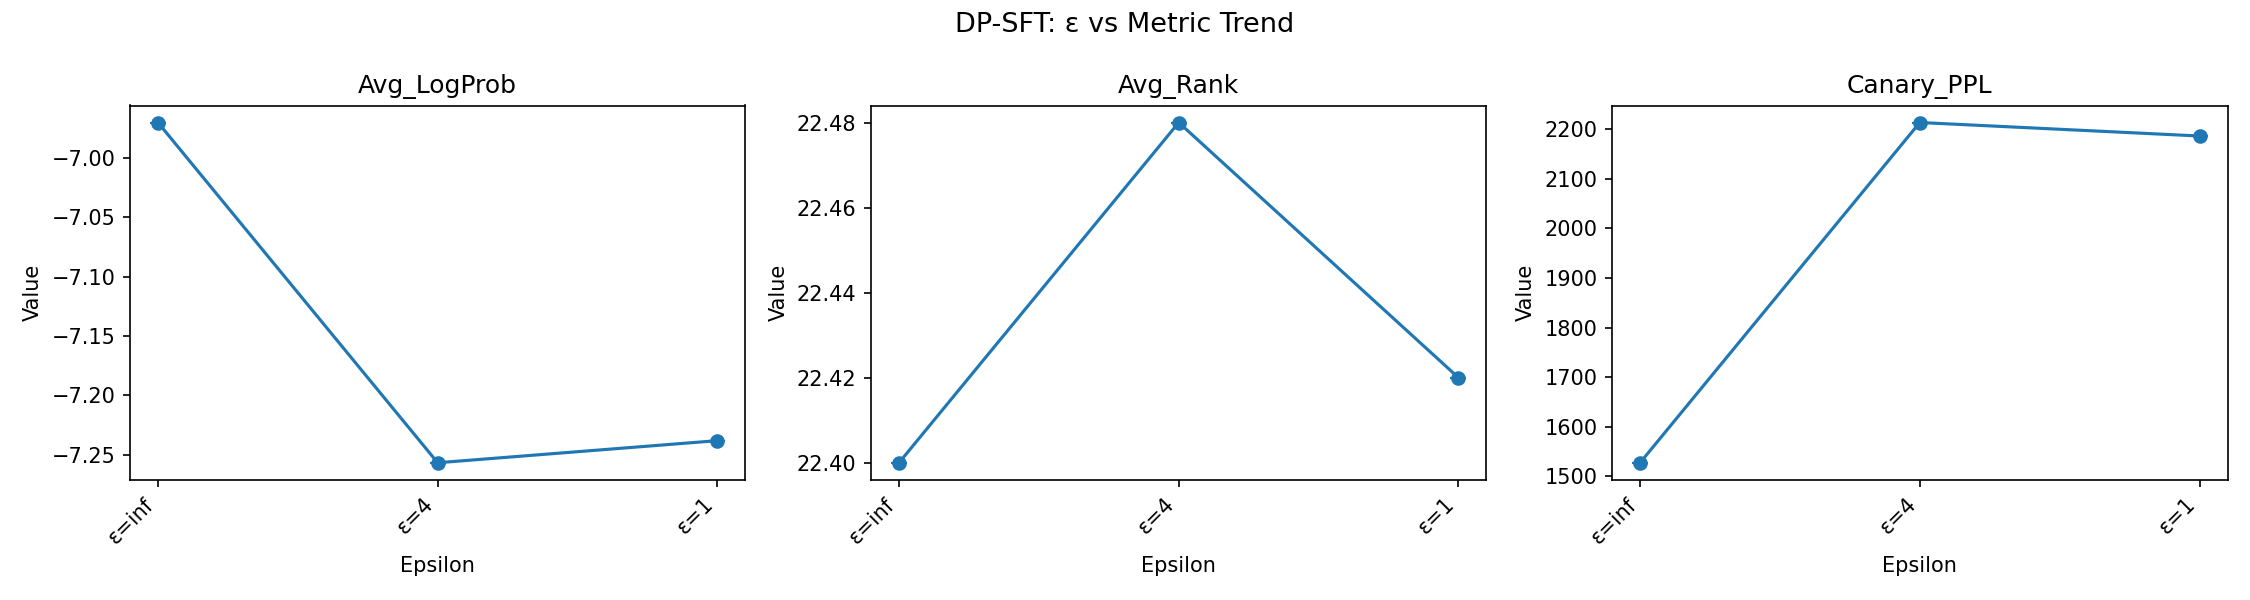

In [19]:
# Display analysis results
import json
from IPython.display import display, Image

analysis_path = "reports/dp_sft_analysis.json"
if os.path.exists(analysis_path):
    with open(analysis_path) as f:
        analysis = json.load(f)
    print("=== DP-SFT Analysis Summary ===")
    print(json.dumps(analysis, indent=2, ensure_ascii=False)[:3000])
else:
    print(f"{analysis_path} not found — run analysis first.")

trend_path = "reports/dp_sft_epsilon_trend.png"
if os.path.exists(trend_path):
    display(Image(filename=trend_path))
else:
    print(f"{trend_path} not found — run analysis first.")